In [22]:
import pandas as pd 
import numpy as np
from pandas_datareader import data as pdr

import yfinance as yf #yahoo finance stock data
import datetime
import matplotlib
import matplotlib.pyplot as plt
from math import sqrt

import tensorflow as tf
from tensorflow import keras

from sklearn.linear_model import LinearRegression,ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz
from sklearn import tree

from keras.models import Sequential
from keras.layers import Activation,Dropout,Dense,LSTM,BatchNormalization

stock="^GSPC"

In [23]:
min_=yf.download(tickers=stock,period="3d",interval="1m")
thirt_min=yf.download(tickers=stock,period="60d", interval="30m")
hour=yf.download(tickers=stock,period="150d",interval="1h")
daily=yf.download(tickers=stock,period="1000d",interval="1d")
weekly=yf.download(tickers=stock,period="3800d",interval="1wk")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [24]:
def Prepare_dataset(df,data_size=255,forecast_window=1):
    from sklearn.model_selection import train_test_split

    df.dropna(inplace=True,how="all",axis=0)
    df.fillna(inplace=True,method="ffill")
    df=df.iloc[-data_size:]
    y=df.shift(-forecast_window).iloc[:-forecast_window,3].values
    X=df.drop("Adj Close",1)
    X=X.iloc[:-forecast_window,:]
    return train_test_split(X, y, test_size=0.2, random_state=0,shuffle=False)

def Mape(y,y_pred):
    mape=np.mean(np.abs((y-y_pred)/y))
    return "{:.2%}".format(mape)

def Rmse(y,y_pred):
    MSE = np.square(np.subtract(y,y_pred)).mean() 
    return sqrt(MSE)

def normalize(data):
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    return (data - data_mean) / data_std


def Arima_build(ts_train,ts_test):
  global arima_model
  def arimamodel(timeseriesarray):
    import pmdarima as pmd
    autoarima_model = pmd.auto_arima(timeseriesarray, 
                              start_p=1,d=1,start_q=0, start_P=0,D=1, start_Q=0,
                              max_p=5,max_d=5,max_q=5, max_P=5,max_D=5,max_Q=5, 
                              m=12, seasonal=True,error_action='warn',trace=True,
                              supress_warnings=True,stepwise=True,
                              random_state=123,n_fits=10)
    return autoarima_model

  arima_model = arimamodel(ts_train)
  preds=arima_model.predict(len(ts_test))
  return preds

def plot_history(history):
    hist=pd.DataFrame(history.history)
    hist["epoch"]=history.epoch

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Abs Error")
    plt.plot(hist.epoch,hist.mae,label="Train error")
    plt.plot(hist.epoch,hist.val_mae,label="Val error")
    plt.legend()
    plt.ylim([0,hist.mae.max()])

def Build_lstm(X_train,X_test,y_train,scale=True):
    keras.backend.clear_session()
    tf.compat.v1.reset_default_graph() 

    global lstm_model

    if scale==True:     
        x_scaler = StandardScaler()
        X_train=x_scaler.fit_transform(X_train)
        X_test=x_scaler.transform(X_test)
        
    x_train=np.array(X_train).reshape(X_train.shape[0],X_train.shape[1],1)
    x_test=np.array(X_test).reshape(X_test.shape[0],X_test.shape[1],1)

    lstm_model = Sequential()
    lstm_model.add(LSTM(64,return_sequences=True))
    lstm_model.add(LSTM(128,return_sequences=False))
    lstm_model.add(Dense(units=32))
    lstm_model.add(Dense(units=1))


    lstm_model.compile(loss="mse",optimizer="nadam",metrics=['accuracy'])
    lstm_model.fit(x_train, np.array(y_train), epochs=1000,verbose=0,batch_size=32)
    preds=lstm_model.predict(x_test, batch_size=1)

    return preds



In [25]:
datasets={}
datasets["1m"]=Prepare_dataset(min_,forecast_window=1)
datasets["30m"]=Prepare_dataset(thirt_min,forecast_window=1)
datasets["1h"]=Prepare_dataset(hour,forecast_window=1)
datasets["D"]=Prepare_dataset(daily,forecast_window=1)
datasets["W"]=Prepare_dataset(weekly,forecast_window=1)

In [26]:
mape=pd.DataFrame(columns=["1m","30m","1h","D","W"])
rmse=pd.DataFrame(columns=["1m","30m","1h","D","W"])

arima_models={}
elastic_nets={}
rf_models={}
ltsm_models={}

preds={}

for key in datasets:
    X_train=datasets[key][0]
    X_test=datasets[key][1]
    y_train=datasets[key][2]
    y_test=datasets[key][3]

    elastic=ElasticNet().fit(X_train, y_train)
    elastic_preds=elastic.predict(X_test)
    mape.loc["Elastic net",key]=[Mape(y_test,elastic_preds)]
    rmse.loc["Elastic net",key]=[Rmse(y_test,elastic_preds)]
    elastic_nets[key]=elastic

    rf=RandomForestRegressor(n_estimators=100,max_depth=4,random_state=0).fit(X_train, y_train)
    rf_preds=rf.predict(X_test)
    mape.loc["Random forest",key]=[Mape(y_test,rf_preds)]
    rmse.loc["Random forest",key]=[Rmse(y_test,rf_preds)]
    rf_models[key]=rf

    arima_preds=Arima_build(datasets[key][0]["Close"],datasets[key][1]["Close"])
    mape.loc["ARIMA",key]=[Mape(y_test,arima_preds)]
    rmse.loc["ARIMA",key]=[Rmse(y_test,arima_preds)]
    arima_models[key]=arima_model

    lstm_preds=Build_lstm(X_train,X_test,y_train) 
    mape.loc["LSTM scaled",key]=[Mape(y_test,lstm_preds)]
    rmse.loc["LSTM scaled",key]=[Rmse(y_test,lstm_preds)]
    ltsm_models[key]=lstm_model

    preds[key]=[arima_preds,elastic_preds,rf_preds,lstm_preds]

    print(f"Model for {key} dataset is done")

Performing stepwise search to minimize aic
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=874.700, Time=0.03 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=873.836, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=812.464, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.35 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=801.768, Time=0.29 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=785.789, Time=0.42 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=785.649, Time=0.92 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=783.555, Time=2.28 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=9.41 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=5.04 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=781.894, Time=1.38 sec
 ARIMA(0,1,0)(4,1,0)[12]             : AIC=783.882, Time=1.23 sec
 ARIMA(0,1,0)(5,1,1)[12]             : AIC=inf, Time=14.51 sec
 ARIMA(0,1,0)(4,1,1)[12]             : AIC=inf, Time=5.58 sec
 ARIMA(0,1,1)(5,1,0)[12]             : AIC=783.617, 

D:\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3261.7673705922452, tolerance: 194.4964841640599
  model = cd_fast.enet_coordinate_descent(


 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1483.131, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1452.307, Time=0.23 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1556.040, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1451.549, Time=0.38 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1483.312, Time=0.10 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1453.164, Time=0.68 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1453.184, Time=1.16 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1451.880, Time=0.97 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1468.646, Time=0.24 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=1455.161, Time=2.06 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1450.830, Time=0.15 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1451.351, Time=0.09 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1484.907, Time=0.07 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=1452.532, Time=0.54 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=1452.514, Time=0.61

D:\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 143290.5369078514, tolerance: 1605.86130312039
  model = cd_fast.enet_coordinate_descent(


 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2029.364, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.37 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1987.361, Time=0.30 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=1979.244, Time=0.68 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=1971.211, Time=1.24 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=1969.907, Time=4.72 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=22.60 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=5.11 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=1970.792, Time=2.73 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=1966.975, Time=4.50 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=1968.145, Time=1.62 sec
 ARIMA(2,1,0)(5,1,1)[12]             : AIC=inf, Time=20.29 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=inf, Time=6.56 sec
 ARIMA(3,1,0)(5,1,0)[12]             : AIC=1968.320, Time=5.02 sec
 ARIMA(2,1,1)(5,1,0)[12]             : AIC=inf, Time=18.86 sec
 ARIMA(1,1,1)(5,1,0)[1

D:\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82065.35761787137, tolerance: 1845.538941894286
  model = cd_fast.enet_coordinate_descent(


 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2215.262, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.24 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=2213.877, Time=0.28 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=2207.532, Time=0.67 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=2204.463, Time=1.28 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=2198.402, Time=3.28 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=2204.745, Time=22.97 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=2197.201, Time=5.82 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=2195.464, Time=3.03 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.98 sec
 ARIMA(1,1,0)(3,1,2)[12]             : AIC=2197.073, Time=2.93 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=2.04 sec
 ARIMA(1,1,0)(4,1,2)[12]             : AIC=2199.342, Time=5.24 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=2193.493, Time=2.86 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=0.67 sec
 ARIMA(0,1,0)(

In [27]:
rmse

,1m,30m,1h,D,W
Elastic net,[3.275843881725161],[11.388176393341574],[15.574408488813349],[33.92335812541555],[93.9769347158158]
Random forest,[10.31680476626095],[29.228759502183237],[22.38016041528991],[184.6622819330876],[578.0083752637871]
ARIMA,[10.082876548921687],[72.82376466518879],[69.76776446247887],[153.37996500681953],[640.9060324922286]
LSTM scaled,[8.072399435659305],[1833.8679219478681],[56.34973049187132],[194.96533401532443],[535.7512038418802]


In [28]:
mape

,1m,30m,1h,D,W
Elastic net,[0.06%],[0.20%],[0.26%],[0.69%],[2.21%]
Random forest,[0.23%],[0.58%],[0.43%],[3.65%],[12.31%]
ARIMA,[0.23%],[1.41%],[1.26%],[3.19%],[15.39%]
LSTM scaled,[0.16%],[20.62%],[1.07%],[3.93%],[11.47%]


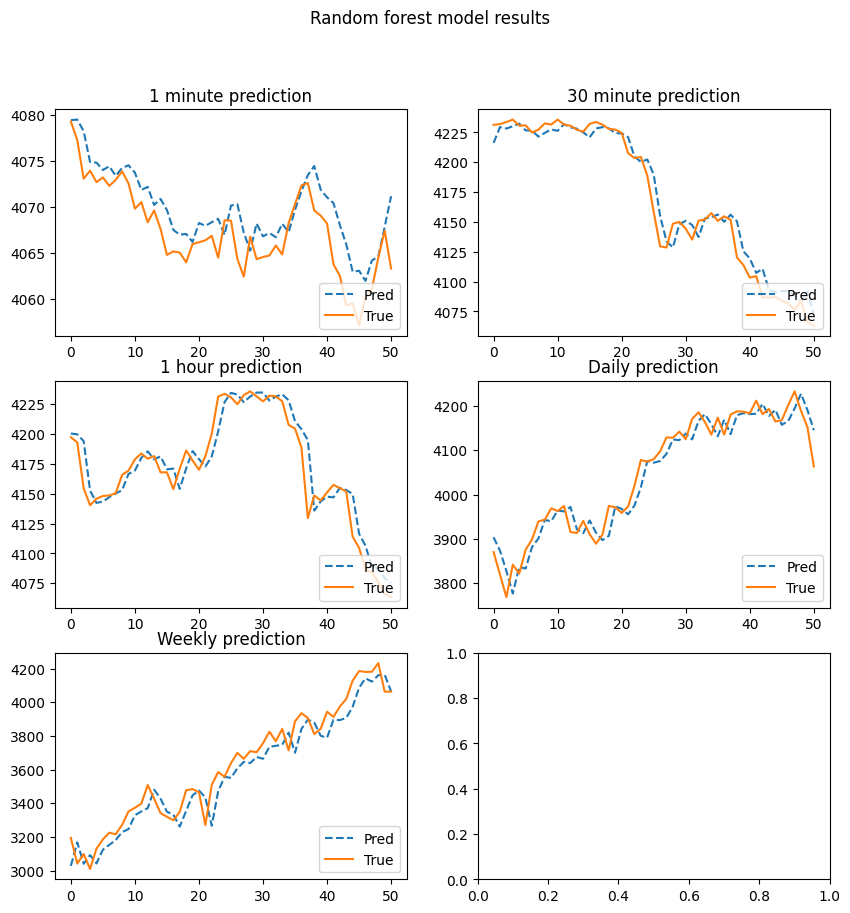

In [10]:
m=1

matplotlib.rcParams.update(matplotlib.rcParamsDefault)

fig, axs = plt.subplots(3, 2,figsize=(10,10))
fig.suptitle('Random forest model results')

axs[0, 0].set_title('1 minute prediction')
axs[0,0].plot(preds['1m'][m], linestyle='dashed',label="Pred")
axs[0,0].plot(datasets['1m'][3],label="True")
axs[0,0].legend(loc="lower right")

axs[0, 1].set_title('30 minute prediction')
axs[0,1].plot(preds['30m'][m], linestyle='dashed',label="Pred")
axs[0,1].plot(datasets['30m'][3],label="True")
axs[0,1].legend(loc="lower right")

axs[1, 0].set_title('1 hour prediction')
axs[1,0].plot(preds['1h'][m], linestyle='dashed',label="Pred")
axs[1,0].plot(datasets['1h'][3],label="True")
axs[1,0].legend(loc="lower right")

axs[1, 1].set_title('Daily prediction')
axs[1,1].plot(preds['D'][m], linestyle='dashed',label="Pred")
axs[1,1].plot(datasets['D'][3],label="True")
axs[1,1].legend(loc="lower right")

axs[2, 0].set_title('Weekly prediction')
axs[2,0].plot(preds['W'][m], linestyle='dashed',label="Pred")
axs[2,0].plot(datasets['W'][3],label="True")
axs[2,0].legend(loc="lower right")
plt.show()

In [33]:
arima_models

{'1m': ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(4, 1, 0, 12),
       suppress_warnings=True, with_intercept=False),
 '30m': ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 1, 1, 12),
       suppress_warnings=True, with_intercept=False),
 '1h': ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(5, 1, 0, 12),
       suppress_warnings=True, with_intercept=False),
 'D': ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(5, 1, 1, 12),
       suppress_warnings=True, with_intercept=False),
 'W': ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 1, 1, 12),
       suppress_warnings=True, with_intercept=False)}

In [ ]:
plot_preds(key):
    preds[key][0]

array([3673.38989258, 3672.91992188, 3673.86010742, 3674.12011719,
       3674.34008789, 3674.01000977, 3675.13989258, 3675.56005859,
       3675.42993164, 3675.51000977, 3675.67993164, 3675.12988281,
       3675.02001953, 3674.72998047, 3674.20996094, 3672.97998047,
       3671.92993164, 3670.95996094, 3671.25      , 3671.56005859,
       3672.57006836, 3671.72998047, 3672.51000977, 3672.79003906,
       3672.80004883, 3673.16992188, 3673.45996094, 3673.12988281,
       3672.91992188, 3672.26000977, 3672.39990234, 3671.20996094,
       3672.20996094, 3673.13989258, 3672.43994141, 3673.06005859,
       3673.11010742, 3672.64990234, 3673.04003906, 3672.75      ,
       3672.27001953, 3672.42993164, 3672.67993164, 3671.0300293 ,
       3670.05004883, 3670.48999023, 3670.23999023, 3670.47998047,
       3670.57006836, 3670.4699707 , 3669.94995117])

In [ ]:
arima_models["1m"],arima_models["30m"],arima_models["1h"],arima_models["D"],arima_models["W"]

(ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 1)),
 ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 1)),
 ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 0, 0, 1)),
 ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 1)),
 ARIMA(order=(1, 1, 3), scoring_args={}, seasonal_order=(0, 0, 0, 1)))

ValueError: Unrecognized location 'upper_center'. Valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center


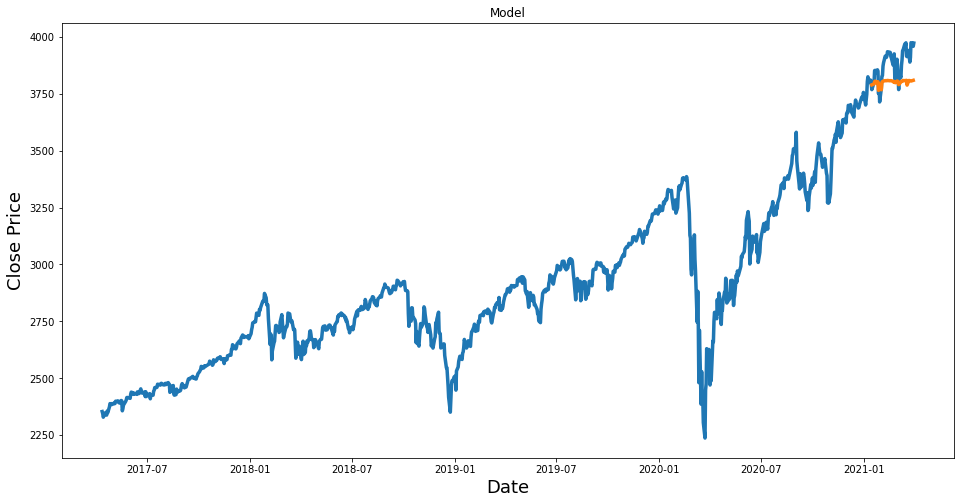

In [ ]:
#train = data[:training_data_len]
#valid = data[training_data_len:]
#valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price' ,fontsize=18)
plt.plot(daily['Close'],linewidth=3.5)
#plt.plot(datasets["W"][1].index,preds["W"][0],linewidth=3.5)
#plt.plot(datasets["W"][1].index,preds["W"][1],linewidth=3.5)
#plt.plot(datasets["W"][1].index,preds["W"][2],linewidth=3.5)
plt.plot(datasets["D"][1].index,preds["D"][3],linewidth=3.5)
plt.legend(['Train','Predictions'], loc='upper_center')